In [1]:
import numpy as np
import time
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from renormalization_np import track_rg_flow

def analyze_coefficients_vs_M_parallel(M_values, J=1.0, n_max=20, n_steps=50, b=2, d=2, n_workers=None):
    """
    Parallelized analysis of how coefficients at the RG sink change with varying M values (4-spin coupling)
    while keeping J (2-spin coupling) fixed.
    
    Args:
        M_values: Array of M values to analyze
        J: Fixed J value to use (default 1.0)
        n_max: Maximum Fourier mode
        n_steps: Number of RG steps
        b: Length rescaling factor
        d: Dimension
        n_workers: Number of workers for parallelization (default: None = auto)
    
    Returns:
        Dictionary with coefficient data
    """
    def process_single_M(M):
        """Process a single M value"""
        # Track the RG flow
        flow_history = track_rg_flow(J, J, M, b, d, n_max, n_steps)
        
        # Extract final coefficients
        final_coeffs = flow_history[-1]
        
        # Store all key coefficients (real parts)
        coeffs = np.zeros(7)
        coeffs[0] = final_coeffs[n_max, n_max].real      # (0,0)
        coeffs[1] = final_coeffs[n_max+1, n_max].real    # (1,0)
        coeffs[2] = final_coeffs[n_max, n_max+1].real    # (0,1)
        coeffs[3] = final_coeffs[n_max+1, n_max+1].real  # (1,1)
        coeffs[4] = final_coeffs[n_max+2, n_max].real    # (2,0)
        coeffs[5] = final_coeffs[n_max, n_max+2].real    # (0,2)
        coeffs[6] = final_coeffs[n_max+2, n_max+2].real  # (2,2)
        
        # Calculate all key ratios
        ratios = np.zeros(6)
        if abs(coeffs[0]) > 1e-10:
            ratios[0] = coeffs[1] / coeffs[0]  # (1,0)/(0,0)
            ratios[1] = coeffs[2] / coeffs[0]  # (0,1)/(0,0)
            ratios[2] = coeffs[3] / coeffs[0]  # (1,1)/(0,0)
            ratios[3] = coeffs[4] / coeffs[0]  # (2,0)/(0,0)
            ratios[4] = coeffs[5] / coeffs[0]  # (0,2)/(0,0)
            ratios[5] = coeffs[6] / coeffs[0]  # (2,2)/(0,0)
        
        # Calculate deviation from Villain form
        villain_deviation = np.nan
        if abs(coeffs[1]) > 1e-10 and abs(coeffs[4]) > 1e-10:
            ratio_10_20 = coeffs[4] / coeffs[1]  # (2,0)/(1,0)
            
            if ratio_10_20 > 0:
                Jv = -3 / (2 * np.log(ratio_10_20))
                
                # Calculate expected values according to Villain model
                expected_values = np.zeros(7)
                
                # Calculate normalization factor
                norm = 0
                for n in range(-min(10, n_max), min(10, n_max)+1):
                    for m in range(-min(10, n_max), min(10, n_max)+1):
                        norm += np.exp(-(n**2 + m**2)/(2*Jv))
                
                # Calculate expected values for each coefficient
                expected_values[0] = 1.0  # (0,0) - normalized to 1
                expected_values[1] = np.exp(-1/(2*Jv))  # (1,0)
                expected_values[2] = np.exp(-1/(2*Jv))  # (0,1)
                expected_values[3] = np.exp(-2/(2*Jv))  # (1,1)
                expected_values[4] = np.exp(-4/(2*Jv))  # (2,0)
                expected_values[5] = np.exp(-4/(2*Jv))  # (0,2)
                expected_values[6] = np.exp(-8/(2*Jv))  # (2,2)
                
                # Calculate deviation from Villain form
                deviation = 0
                for j in range(7):
                    if abs(coeffs[0]) > 1e-10:
                        norm_coeff = coeffs[j] / coeffs[0]
                        norm_expected = expected_values[j] / expected_values[0]
                        deviation += (norm_coeff - norm_expected)**2
                
                villain_deviation = np.sqrt(deviation)
        
        return coeffs, ratios, villain_deviation
    
    # Initialize arrays
    n_coeffs = 7  # Now storing 7 coefficients
    coefficients = np.zeros((len(M_values), n_coeffs))
    ratios = np.zeros((len(M_values), 6))  # Now storing 6 ratios
    villain_deviation = np.zeros(len(M_values))
    
    # Set up the number of workers (physical cores)
    if n_workers is None:
        try:
            # Try to get physical core count using psutil
            import psutil
            n_workers = psutil.cpu_count(logical=False)
            if n_workers is None:  # Fallback if psutil can't determine
                n_workers = max(1, (psutil.cpu_count() or 4) // 2)  # Estimate physical cores
        except ImportError:
            # If psutil not available, estimate physical cores
            import multiprocessing as mp
            n_workers = max(1, mp.cpu_count() // 2)  # Most CPUs have 2 threads per core
    
    # Process M values in parallel with joblib
    print(f"Processing {len(M_values)} M values using {n_workers} workers...")
    start_time = time.time()
    
    # The verbose parameter enables a progress bar
    results = Parallel(n_jobs=n_workers, verbose=10)(
        delayed(process_single_M)(M) for M in M_values
    )
    
    elapsed = time.time() - start_time
    print(f"Processing complete! Elapsed time: {elapsed:.1f}s")
    
    # Unpack results
    for i, (coeffs, rats, vd) in enumerate(results):
        coefficients[i] = coeffs
        ratios[i] = rats
        villain_deviation[i] = vd
    
    # Return results dictionary with expanded labels
    return {
        'M_values': M_values,
        'J': J,
        'coefficients': coefficients,
        'ratios': ratios,
        'villain_deviation': villain_deviation,
        'coeff_labels': ['(0,0)', '(1,0)', '(0,1)', '(1,1)', '(2,0)', '(0,2)', '(2,2)'],
        'ratio_labels': ['(1,0)/(0,0)', '(0,1)/(0,0)', '(1,1)/(0,0)', 
                         '(2,0)/(0,0)', '(0,2)/(0,0)', '(2,2)/(0,0)']
    }

In [3]:
def plot_normalized_coefficients(results, coeffs_to_show=None, figsize=(10, 6), ylim=None, 
                                set_log_scale=False, add_villain_estimate=True):
    """
    Plot normalized Fourier coefficients as a function of the varying parameter (M).
    
    Args:
        results: Results dictionary from analyze_coefficients_vs_M_parallel
        coeffs_to_show: List of coefficient labels to display (e.g., ['(1,0)', '(2,0)'])
                        If None, all coefficients except (0,0) will be shown
        figsize: Figure size tuple (default: (10, 6))
        ylim: Optional y-axis limits as a tuple (ymin, ymax)
        set_log_scale: Whether to use log scale for y-axis
        add_villain_estimate: Whether to add Villain model estimates for comparison
        
    Returns:
        Matplotlib figure
    """
    # Extract values
    M_values = results['M_values']
    J = results['J']
    coefficients = results['coefficients']
    coeff_labels = results['coeff_labels']
    
    # Define which coefficients to show
    if coeffs_to_show is None:
        # Show all except (0,0) which is always 1 when normalized
        coeffs_to_show = coeff_labels[1:]
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate normalized coefficients
    norm_coeffs = np.zeros_like(coefficients)
    for i in range(len(M_values)):
        if abs(coefficients[i, 0]) > 1e-10:
            norm_coeffs[i] = coefficients[i] / coefficients[i, 0]
        else:
            norm_coeffs[i] = np.zeros_like(coefficients[i])
    
    # Colors for different coefficients
    colors = {
        '(1,0)': 'blue',
        '(0,1)': 'green',
        '(1,1)': 'red',
        '(2,0)': 'purple',
        '(0,2)': 'brown',
        '(2,2)': 'teal'
    }
    
    # Markers for different coefficients
    markers = {
        '(1,0)': 'o',
        '(0,1)': 's',
        '(1,1)': 'd',
        '(2,0)': 'h',
        '(0,2)': 'p',
        '(2,2)': '*'
    }
    
    # Plot normalized coefficients
    for label in coeffs_to_show:
        if label in coeff_labels:
            idx = coeff_labels.index(label)
            valid = ~np.isnan(norm_coeffs[:, idx]) & ~np.isinf(norm_coeffs[:, idx])
            if np.any(valid):
                ax.plot(M_values[valid], norm_coeffs[valid, idx], 
                        marker=markers.get(label, 'o'), markersize=6, linestyle='-', linewidth=2, 
                        color=colors.get(label, 'black'), 
                        label=f'$\\lambda_{{{label}}}/\\lambda_{{(0,0)}}$')
    
    # Add Villain model estimates if requested
    if add_villain_estimate:
        # Calculate Jv from (1,0) and (2,0) coefficients at M=0
        # Find index closest to M=0
        m0_idx = np.argmin(np.abs(M_values))
        
        # Only calculate if we have valid coefficients near M=0
        if (abs(norm_coeffs[m0_idx, 1]) > 1e-10 and  # (1,0)
            abs(norm_coeffs[m0_idx, 4]) > 1e-10):    # (2,0)
            
            ratio_10_20 = norm_coeffs[m0_idx, 4] / norm_coeffs[m0_idx, 1]
            if ratio_10_20 > 0:
                Jv_estimate = -3 / (2 * np.log(ratio_10_20))
                
                # Calculate expected values for each coefficient at M=0
                villain_values = {}
                for label in coeffs_to_show:
                    if label in coeff_labels:
                        # Get n,m indices
                        n = int(label[1])
                        m = int(label[3])
                        # Villain coefficient formula
                        exponent = -(n**2 + m**2) / (2 * Jv_estimate)
                        villain_values[label] = np.exp(exponent)
                
                # Add Villain reference lines
                for label, value in villain_values.items():
                    ax.axhline(y=value, color=colors.get(label, 'black'), 
                              linestyle='--', alpha=0.5,
                              label=f'Villain est. for {label}')
    
    # Set y-scale if requested
    if set_log_scale:
        ax.set_yscale('log')
    
    # Set y-limits if provided
    if ylim is not None:
        ax.set_ylim(ylim)
    
    # Add labels and title
    ax.set_xlabel('Four-spin Interaction (M)', fontsize=12)
    ax.set_ylabel('Normalized Coefficient Value $\\lambda_{(n,m)}/\\lambda_{(0,0)}$', fontsize=12)
    ax.set_title(f'Normalized Fourier Coefficients vs M (J={J})', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10, loc='best')
    
    # Add a vertical line at M=0 to highlight the pure XY case
    ax.axvline(x=0, color='black', linestyle=':', alpha=0.7)
    
    fig.tight_layout()
    return fig

def plot_coefficient_correlation_general(results, x_coeff='(1,0)', y_coeff='(2,0)', figsize=(9, 7)):
    """
    Generalized coefficient correlation plot for examining Villain relations.
    
    Args:
        results: Results dictionary from coefficient analysis
        x_coeff: x-axis coefficient label, e.g. '(1,0)' 
        y_coeff: y-axis coefficient label, e.g. '(2,0)'
        figsize: Figure size tuple
        
    Returns:
        Matplotlib figure with coefficient correlation plot
    """
    # Extract values
    J_values = results.get('J_values')
    M_values = results.get('M_values')
    if J_values is not None:
        var_values = J_values
        var_name = 'J'
        var_label = 'J Value'
        fixed_value = results.get('M', 0)
        fixed_name = 'M'
    else:
        var_values = M_values
        var_name = 'M'
        var_label = 'M Value'
        fixed_value = results.get('J', 0)
        fixed_name = 'J'
    
    coefficients = results['coefficients']
    coeff_labels = results['coeff_labels']
    
    # Get indices for the selected coefficients
    try:
        x_idx = coeff_labels.index(x_coeff)
        y_idx = coeff_labels.index(y_coeff)
    except ValueError:
        print(f"Error: Coefficient labels must be in {coeff_labels}")
        return None
    
    # Create figure for correlation plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Normalize coefficients for better comparison
    norm_coeffs = np.zeros_like(coefficients)
    for i in range(len(var_values)):
        if abs(coefficients[i, 0]) > 1e-10:
            norm_coeffs[i] = coefficients[i] / coefficients[i, 0]
    
    # Create parametric plot of coefficients
    # Filter out any NaN or infinite values
    valid_mask = (~np.isnan(norm_coeffs[:, x_idx])) & (~np.isnan(norm_coeffs[:, y_idx])) & \
                 (~np.isinf(norm_coeffs[:, x_idx])) & (~np.isinf(norm_coeffs[:, y_idx]))
    
    if np.any(valid_mask):
        scatter = ax.scatter(norm_coeffs[valid_mask, x_idx], norm_coeffs[valid_mask, y_idx], 
                   c=var_values[valid_mask], cmap='viridis', s=60, alpha=0.8)
        
        # Add color bar to show variable values
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label(var_label, fontsize=10)
        
        # Calculate exponent for the Villain relation
        # Parse indices from the coefficient labels
        x_n = int(x_coeff[1])
        x_m = int(x_coeff[3])
        y_n = int(y_coeff[1])
        y_m = int(y_coeff[3])
        
        x_sum_squares = x_n**2 + x_m**2
        y_sum_squares = y_n**2 + y_m**2
        
        # The Villain exponent is the ratio of the sum of squared indices
        exponent = y_sum_squares / x_sum_squares if x_sum_squares > 0 else 1
        
        # Add Villain relation curve for reference
        x_max = np.nanmax(norm_coeffs[valid_mask, x_idx])
        x_range = np.linspace(0, max(x_max*1.1, 1.0), 100)
        villain_curve = x_range**exponent
        
        ax.plot(x_range, villain_curve, 'k--', alpha=0.7, 
                label=f'Villain Relation: $\\lambda_{{{y_coeff}}} \\sim [\\lambda_{{{x_coeff}}}]^{{{exponent:.1f}}}$')
        
        ax.set_xlabel(f'$\\lambda_{{{x_coeff}}}/\\lambda_{{(0,0)}}$', fontsize=12)
        ax.set_ylabel(f'$\\lambda_{{{y_coeff}}}/\\lambda_{{(0,0)}}$', fontsize=12)
        ax.set_title(f'Coefficient Correlation ({fixed_name}={fixed_value})', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left', fontsize=10)
    else:
        ax.text(0.5, 0.5, 'No valid data points to plot', 
                horizontalalignment='center', fontsize=14, transform=ax.transAxes)
    
    plt.tight_layout()
    return fig

In [29]:
# Define M values to analyze
M_values = np.linspace(-3.0, 7.0, 100)

# Run analysis in parallel for fixed non-zero J
results = analyze_coefficients_vs_M_parallel(M_values, J=0, n_max=20, n_steps=10, b=3, d=2, n_workers=4)

Processing 100 M values using 4 workers...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
100%|██████████| 10/10 [00:25<00:00,  2.51s/it]
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   50.2s
100%|██████████| 10/10 [00:24<00:00,  2.50s/it]
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.3min
100%|██████████| 10/10 [00:24<00:00,  2.49s/it]
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  2.1min
100%|██████████| 10/10 [00:31<00:00,  3.16s/it]
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.7min
100%|██████████| 10/10 [00:33<00:00,  3.37s/it]
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.4min
100%|██████████| 10/10 [00:34<00:00,  3.46s/it]
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.6min
100%|██████████| 10/10 [00:30<00:00,  3.03s/it]
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  7.2min
100%|██████████| 10/10 [00:37<00:00,  3.78s/it]
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  8.5min
100%|██████████| 10/10 [00:30<00:00,  3.02s/it]
[Para

Processing complete! Elapsed time: 798.7s


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 13.3min finished


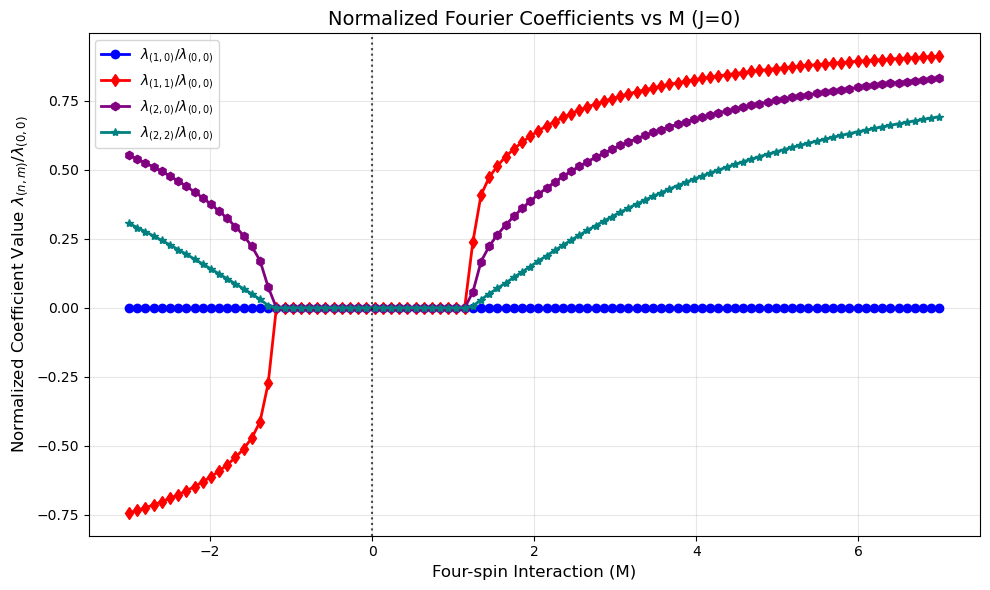

In [39]:
# Plot results
normalized_coefficients_zero_J_fig = plot_normalized_coefficients(results, coeffs_to_show=['(1,0)', '(1,1)', '(2,0)', '(2,2)'],
                                                                  figsize=(10, 6), ylim=None,
                                                                  set_log_scale=False, add_villain_estimate=True)
plt.show()

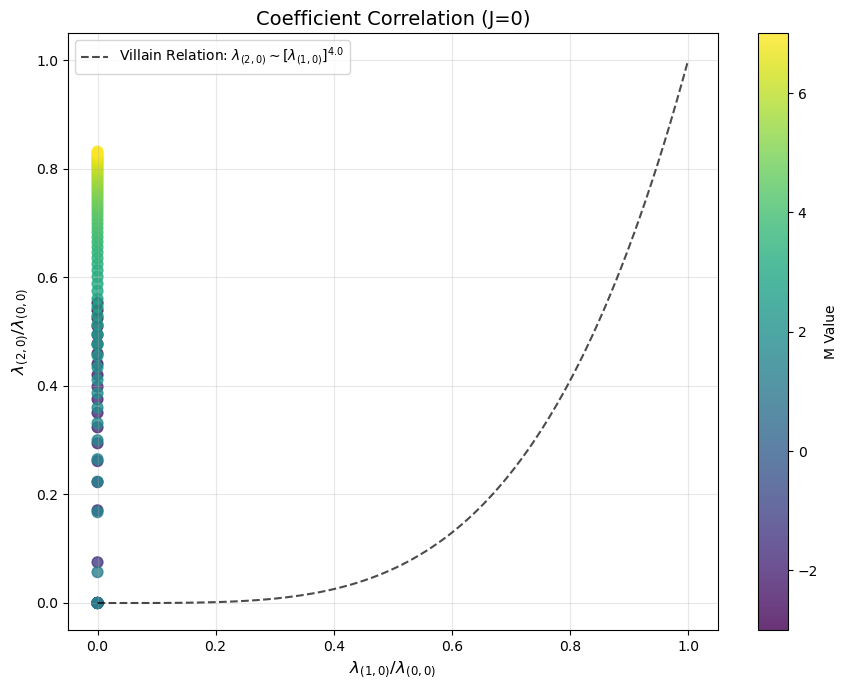

In [36]:
coefficient_correlation_fig = plot_coefficient_correlation_general(results, x_coeff='(1,0)', y_coeff='(2,0)', figsize=(9, 7))
plt.show()